In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr, spearmanr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from apa_variant_prediction_utils import *


In [2]:
#Variant data parameters

isoform_pseudo_count = 1.
proximal_start = 65
proximal_end = 90

file_prefix = str(proximal_start) + "_" + str(proximal_end)


In [3]:
#Code to aggregate predictions by over barcodes

def _collapse_pred_cuts(pred_df, pred_cuts) :
    
    #Group by master_seq
    pred_df['row_ix'] = np.arange(len(pred_df), dtype=np.int)
    
    cut_map_dict = {}
    for _, row in pred_df.iterrows() :
        if row['master_seq'] not in cut_map_dict :
            cut_map_dict[row['master_seq']] = []
        
        cut_map_dict[row['master_seq']].append(row['row_ix'])
    
    #Collapse predicted cut profile by master_seq
    pred_df_agg = pred_df.groupby('master_seq').agg({'iso_pred' : 'mean', 'logodds_pred' : 'mean'}).reset_index().reset_index(drop=True)
    
    pred_cuts_agg = np.zeros((len(pred_df_agg), pred_cuts.shape[1]))
    
    pred_cuts_dense = np.array(pred_cuts.todense())
    
    new_row_ix = 0
    for _, row in pred_df_agg.iterrows() :
        
        row_index = cut_map_dict[row['master_seq']]
        
        pred_cuts_agg[new_row_ix, :] = 0.
        
        for row_ix in row_index :
            pred_cuts_agg[new_row_ix, :] += pred_cuts_dense[row_ix, :] / float(len(row_index))
        
        new_row_ix += 1
    
    return pred_df_agg, sp.csr_matrix(pred_cuts_agg)


In [4]:
#Load variant dataframe
seq_dict = isoio.load('../../aparent/data/prepared_data/apa_array_data/apa_array_data_seq')
variant_dict = isoio.load('../../aparent/data/prepared_data/apa_variant_data/apa_variant_data_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions (Resnet)
model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_seq')

pred_dict['array_df'], pred_dict['cut_prob'] = _collapse_pred_cuts(pred_dict['array_df'], pred_dict['cut_prob'])

pred_dict['cut_prob'] = pred_dict['cut_prob'][:, 20:]

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'], proximal_start=proximal_start, proximal_end=proximal_end, isoform_pseudo_count=isoform_pseudo_count)


n (variants) = 491446


In [5]:
#Mark wildtype TGTA-containing sequences

variant_df['tgta_fixed'] = variant_df['wt_seq'].str.contains("TGTA")

#Set prediction columns
variant_df['delta_logodds_pred'] = variant_df['delta_logodds_pred_from_cuts']


In [6]:
#Extract TGTA insertion simulation data

tgta_1_df = variant_df.query("experiment == 'tgta' and subexperiment == 'n=1' and tgta_fixed == False").copy().reset_index(drop=True)


In [7]:
#Re-map TGTA insertion positions

def _get_tgta_pos_1(row) :
    pos = -1
    for j in range(len(row['wt_seq']) - 4 + 1) :
        if row['wt_seq'][j:j+4] != "TGTA" and row['master_seq'][j:j+4] == "TGTA" :
            pos = j
            break
    
    return pos

def _get_tgta_pos_2(row) :
    pos = -1
    for j in range(len(row['wt_seq']) - 4, -1, -1) :
        if row['wt_seq'][j:j+4] != "TGTA" and row['master_seq'][j:j+4] == "TGTA" :
            pos = j
            break
    
    return pos

tgta_1_df['tgta_pos'] = tgta_1_df.apply(_get_tgta_pos_1, axis=1).astype(int)


In [8]:

tgta_1_df = tgta_1_df[['master_seq', 'wt_seq', 'seq_ref', 'seq_var', 'tgta_pos', 'delta_logodds_true', 'mean_total_count_var', 'mean_total_count_ref']].copy()


In [9]:

tgta_1_df['barcode_ref'] = tgta_1_df['seq_ref'].str.slice(0, 20)
tgta_1_df['barcode_var'] = tgta_1_df['seq_var'].str.slice(0, 20)
tgta_1_df['barcode_full'] = tgta_1_df['barcode_ref'] + tgta_1_df['barcode_var']


In [10]:

tgta_1_df_repl = tgta_1_df.join(tgta_1_df.set_index("master_seq"), on='master_seq', how='inner', rsuffix='_repl').copy().reset_index(drop=True)
tgta_1_df_repl = tgta_1_df_repl.query("barcode_full < barcode_full_repl").copy().reset_index(drop=True)


In [11]:

tgta_1_df_repl[['master_seq', 'wt_seq', 'delta_logodds_true', 'delta_logodds_true_repl']]


,master_seq,wt_seq,delta_logodds_true,delta_logodds_true_repl
0,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGTG...,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCG...,0.808606,0.919817
1,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGTG...,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCG...,0.808606,0.976976
2,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGTG...,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCG...,0.808606,0.764654
3,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGTG...,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCG...,0.808606,0.356518
4,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGTG...,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCG...,0.808606,0.347847
5,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGTG...,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCG...,0.808606,0.459058
6,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGTG...,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCG...,0.808606,0.516216
7,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGTG...,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCG...,0.808606,0.303895
8,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGTG...,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCG...,0.808606,-0.104241
9,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGTG...,ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCG...,0.808606,0.374007


wt_ix = 0 (ACCTACGTTTGAGATACCTTCCGGGATTCTCCCAACGTTGCAGGCGTCATAATAAAGAGGAATGGTGTGTTGGTCTGTGTCTCGTTCATTGCTGGTCGAGCTTACATTCCACGTTCGTCTGCTTCCGATACCCCGTATATAGGTCTTTGGAAGACGTATCCCCG)


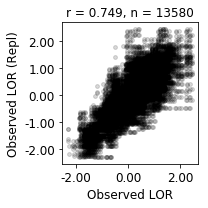

wt_ix = 1 (ACTTCGCTTCCTGCGTTTATCTAGCCAAACATGGTAAGACTACGACTTCAAATAAATCGACTTCCCGCCAGACGGTGTGTCTCGTCGAGCCCGTAGAACTGATCGGCACAGTATTAGTCAGAGCCTTCTACAGCCGTCGTTAGACTTATATGAGTGGCTGGCTT)


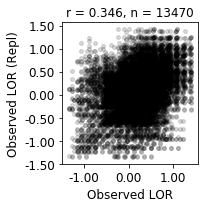

wt_ix = 2 (GTCCCATCCACTAGTTCCCATTCTTGCATAGGTCTCCGGAGTGCGCCTCCAATAAAGGTAGTCACGTTTCCGTGCTGTGTCTCGTGGCGGAACGCGGCCGCGCTGTCAGTATGTCTTAGCCGAAATTGCCGCGACGACAACTTCACGCTGAATAGTAGTGGGCA)


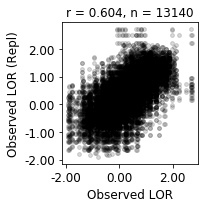

In [14]:
#Single TGTA Repl Analysis

from scipy.stats import pearsonr

min_c = 100

wt_seqs = np.unique(tgta_1_df_repl['wt_seq']).tolist()

for wt_ix, wt_seq in enumerate(wt_seqs) :
    
    print("wt_ix = " + str(wt_ix) + " (" + str(wt_seq) + ")")
    
    sel_df = tgta_1_df_repl.query("wt_seq == '" + str(wt_seq) + "' and mean_total_count_ref >= " + str(min_c) + " and mean_total_count_var >= " + str(min_c) + " and mean_total_count_ref_repl >= " + str(min_c) + " and mean_total_count_var_repl >= " + str(min_c)).sort_values(by='tgta_pos').copy().reset_index(drop=True)
    
    r_val = np.round(spearmanr(sel_df.query("tgta_pos < 50-4 or tgta_pos >= 56")['delta_logodds_true'], sel_df.query("tgta_pos < 50-4 or tgta_pos >= 56")['delta_logodds_true_repl'])[0], 3)
    
    f = plt.figure(figsize=(3, 3))
    
    plt.scatter(sel_df.query("tgta_pos < 50-4 or tgta_pos >= 56")['delta_logodds_true'], sel_df.query("tgta_pos < 50-4 or tgta_pos >= 56")['delta_logodds_true_repl'], s=15, color='black', alpha=0.15)

    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xlabel("Observed LOR", fontsize=12)
    plt.ylabel("Observed LOR (Repl)", fontsize=12)
    
    plt.title("r = " + str(r_val) + ", n = " + str(len(sel_df.query("tgta_pos < 50-4 or tgta_pos >= 56"))))
    
    plt.tight_layout()
    
    plt.savefig("tgta_1_repl_scatter_wt_ix_" + str(wt_ix) + "_aparent_resnet_seq.png", transparent=True, dpi=300)
    plt.savefig("tgta_1_repl_scatter_wt_ix_" + str(wt_ix) + "_aparent_resnet_seq.eps")
    
    plt.show()
